In [53]:
import pygmt
import numpy as np
import pandas as pd
region = [-10.5, -5, 51.5, 55.5]
seisblast_files = '/home/bmelo/bin/SeisBlast/files'
seisblast_codes = '/home/bmelo/bin/SeisBlast/codes'

**Function to prepare and select the blast catalogue data per quarry**

In [59]:
def quarry_select(quarry_locations_df, blast_catalogue_df, radius):
    """
    Relocate blasts using GMT select based on quarry locations and a specified radius.
    Parameters:
    quarry_locations_df (pd.DataFrame): DataFrame containing quarry locations with columns 'lat' and 'lon'.
    blast_catalogue_df (pd.DataFrame): DataFrame containing blast events with columns 'LON(deg)', 'LAT(deg)', and 'EVENT-ID'.
    radius (str): Radius for selection in GMT format (e.g., '10k' for 10 kilometers).
    Returns:
    tuple: A tuple containing:
        - relocated_blasts (pd.DataFrame): DataFrame of relocated blasts with columns 'lon_ev', 'lat_ev', 'id-ev', 'lon-quarry', 'lat-quarry'.
        - remain_blasts (pd.DataFrame): DataFrame of remaining blasts that were not relocated.
        - repeated_blasts (pd.DataFrame): DataFrame of blasts that were assigned to more than one quarry location.
    """

    relocated_blasts = pd.DataFrame()
    repeated_blasts = pd.DataFrame()
    result = pd.DataFrame()
    
    #convert the blast catalogue dataframe to lon, lat (ASCII) to load into gmt select
    blast_catalogue_df.to_csv(f'{seisblast_files}/Eire_blasts.gmt', 
            columns=['LON(deg)','LAT(deg)','EVENT-ID'], 
            sep="\t", 
            header=False, 
            index=False)

    for index, row in quarry_locations_df.iterrows():
        quarry_lat = quarry_locations_df.loc[index, "lat"]
        quarry_lon = quarry_locations_df.loc[index, "lon"]
        quarry_loc = str(quarry_lon) + "/" + str(quarry_lat)

        result = pygmt.select(
            data="Eire_blasts.gmt",
            output_type="pandas",
            dist2pt=quarry_loc + "+d" + radius,
            region=region,
        )

        if not result.empty:
            result["new-lon"] = quarry_lon
            result["new-lat"] = quarry_lat
            relocated_blasts = pd.concat([relocated_blasts, result], ignore_index=True)

    if not relocated_blasts.empty:
        relocated_blasts.columns = [
            "lon_ev",
            "lat_ev",
            "id-ev",
            "lon-quarry",
            "lat-quarry",
        ]
    
        # Filter values that appear more than once
        value_counts = relocated_blasts['id-ev'].value_counts()
        repeated_values = value_counts[value_counts > 1]
        
        # Check if there are no repeated values
        if not repeated_values.any():
            print('    ~~~the selection radius '+str(radius)+' found ' +str(relocated_blasts.shape[0])+' matches and no double assigments.')
        else: 
            # If there are repeated values, print the number of non-unique assignments
            print('    ~~~the selection radius '+str(radius)+' found ' +str(relocated_blasts.shape[0])+' matches and '+str(repeated_values.iloc[0].max())+' non-unique assigments.')
            repeated_blasts = relocated_blasts[relocated_blasts['id-ev'].isin(repeated_values.index)]
            relocated_blasts = relocated_blasts[~relocated_blasts['id-ev'].isin(repeated_values.index)]
        
        # Build new event list with the remaining blasts
        remain_blasts = blast_catalogue_df[~blast_catalogue_df['EVENT-ID'].isin(relocated_blasts["id-ev"])]
        print("    ~~~out of "+str(blast_catalogue_df.shape[0])+" initial events, "+str(remain_blasts.shape[0])+" quarry blast events remain")
    else:
        # If no matches were found
        print('    ~~~the selection radius '+str(radius)+' found no matches.')
        
    return relocated_blasts, remain_blasts, repeated_blasts

**Load station,  quarry and blast data**

In [55]:
# Load station data to lon lat file and dataframe
stations_head = ['sta', 'name','lat', 'lon', 'elevation', 'net', 'end']
stations = pd.read_csv(
    "/mnt/store/senad/repos/for_bruna/QUARRY_BLASTS/ADMIN/Ireland_Britain_Stations", 
    delimiter=' ',
    names=stations_head)

In [56]:
quarries = pd.read_csv(
    '/home/bmelo/bin/Quarry/quarry_new_update1.gmt',
    header=0, 
    sep=r'\s+',
    names=['lon','lat'])
quarries['z']=1


In [ ]:
#kind of empirically tested radius values to select the quarry blasts without double assigments
#by double assigments we mean that the same blast is assigned to more than one quarry
#from 0.5 to 8 km search in ~250m steps
radius = np.concatenate((np.linspace(0.005, 0.0095, int((0.0095 - 0.005) / 0.0005) + 1), 
						 np.linspace(0.01, 0.08, int((0.08 - 0.01) / 0.0025) + 1)))

# Initialize relocated_blasts_all
relocated_blasts_all = pd.DataFrame()
doubles_all = pd.DataFrame()
blasts_catalogue = pd.read_csv(r'/mnt/REPO/QUARRY-BLASTS/CATALOGS/quarry-blast-catalog-2013-2014.csv', 
                     sep=r'\s+')

remain_blasts_catalogue = blasts_catalogue
for r in radius:
    print(" ")
    print(" >>processing radius "+str(r))
    quarry_blasts, remain_blasts_catalogue, doubles = quarry_select(quarries, remain_blasts_catalogue, str(r))
    relocated_blasts_all = pd.concat([relocated_blasts_all, quarry_blasts], ignore_index=True)
    doubles_all = pd.concat([doubles_all, doubles], ignore_index=True)
    
relocated_blasts_all.to_csv(f'{seisblast_files}/Eire_blasts_relocated.csv', index=False)

unique_id_ev_count = doubles_all['id-ev'].nunique()
print(f" >>number of doubles': {unique_id_ev_count}")
doubles_filter = doubles_filter.drop_duplicates().sort_values(by='id-ev')
doubles_filter.to_csv(f'{seisblast_files}/Eire_blasts_toreview.csv', index=False)


 
 >>processing radius 0.005


    ~~~the selection radius 0.005 found 93 matches and no double assigments.
    ~~~out of 1411 initial events, 1318 quarry blast events remain
 
 >>processing radius 0.0055
    ~~~the selection radius 0.0055 found 22 matches and no double assigments.
    ~~~out of 1318 initial events, 1296 quarry blast events remain
 
 >>processing radius 0.006
    ~~~the selection radius 0.006 found 22 matches and no double assigments.
    ~~~out of 1296 initial events, 1274 quarry blast events remain
 
 >>processing radius 0.006500000000000001
    ~~~the selection radius 0.006500000000000001 found 12 matches and no double assigments.
    ~~~out of 1274 initial events, 1262 quarry blast events remain
 
 >>processing radius 0.007
    ~~~the selection radius 0.007 found 20 matches and no double assigments.
    ~~~out of 1262 initial events, 1242 quarry blast events remain
 
 >>processing radius 0.0075
    ~~~the selection radius 0.0075 found 28 matches and no double assigments.
    ~~~out of 1242 initi

**Plot results with PyGMT**

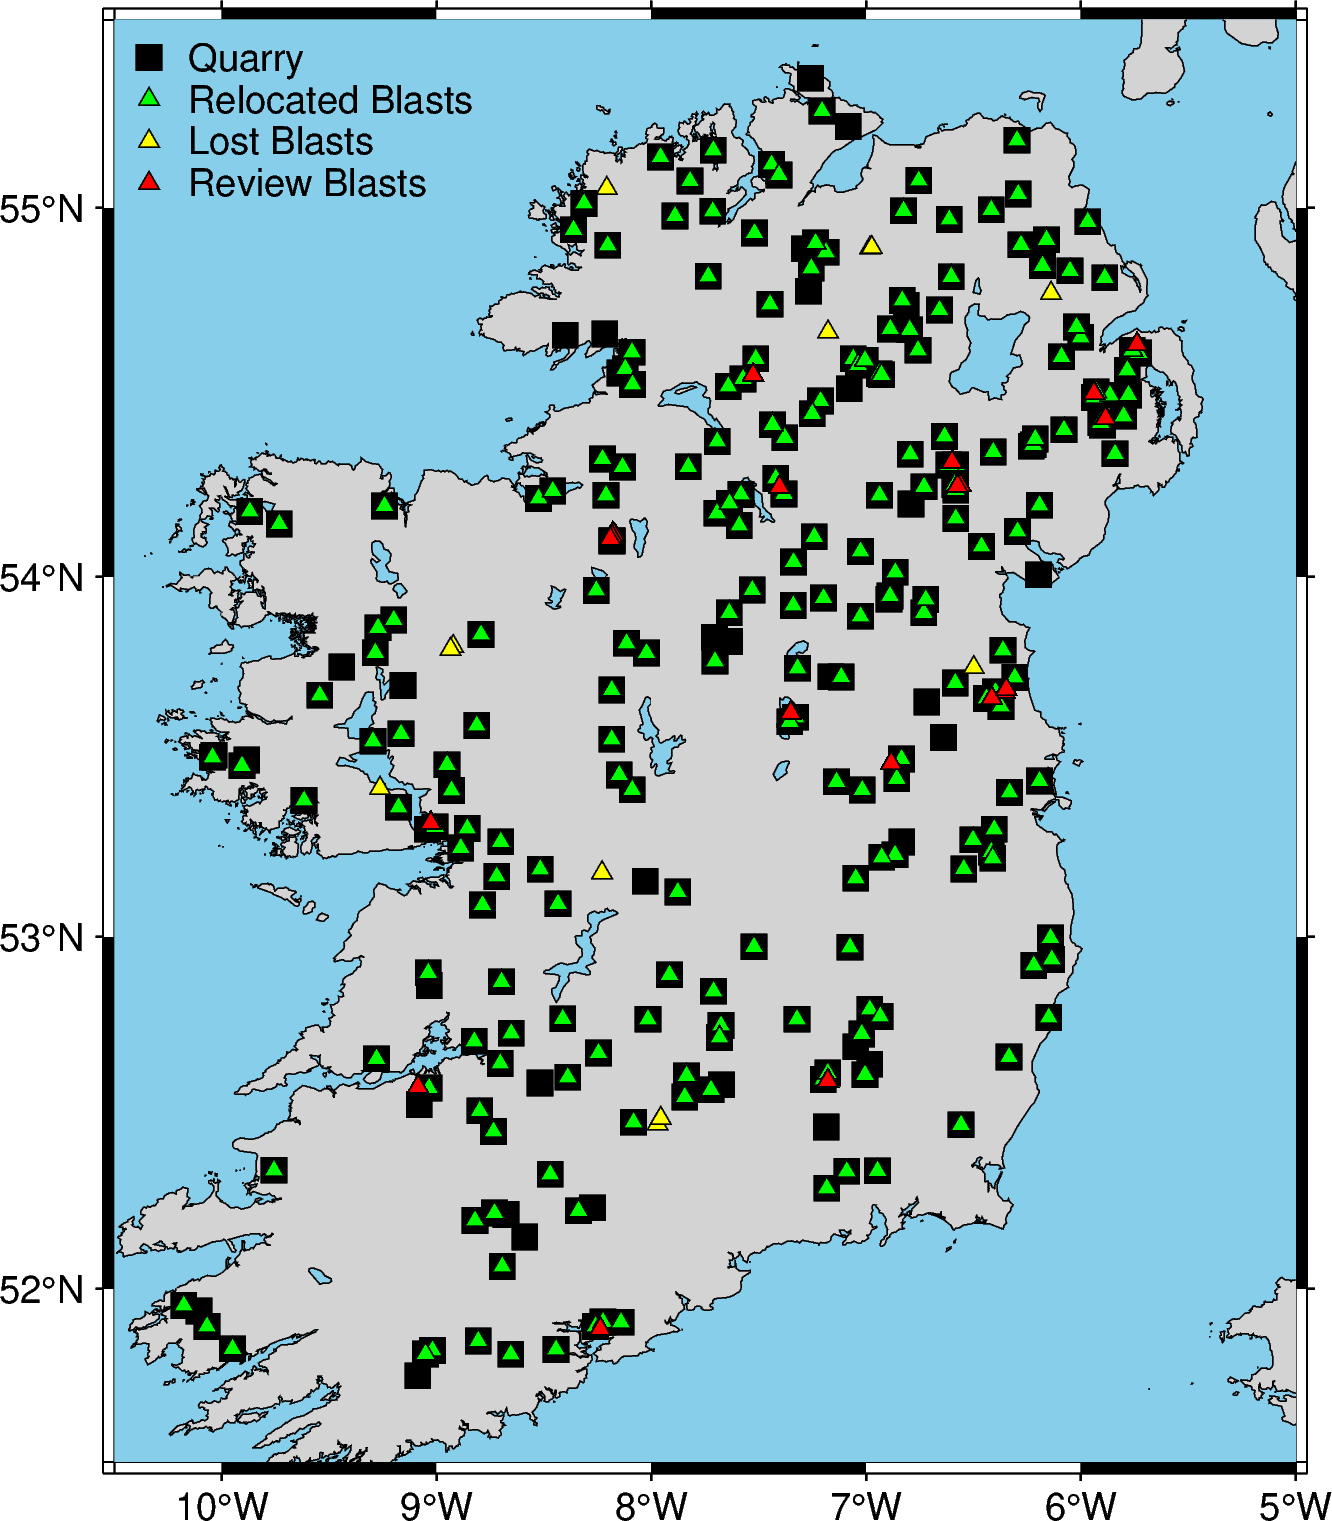

In [58]:
fig = pygmt.Figure()
fig.basemap(region=region, projection="M10c", frame="a1")
fig.coast(shorelines=True, water="skyblue", land="lightgray")
#Plot quarry mine locations as black circles
fig.plot(
    x=quarries["lon"],
    y=quarries["lat"],
    style="s0.3c",
    fill="black",
    pen="black",
    label="Quarry"
)
#Plot relocated blasts as red circles
fig.plot(x=relocated_blasts_all["lon-quarry"],
         y=relocated_blasts_all["lat-quarry"],
         style="t0.2c",
         fill="green",
         pen="black",
         label="Relocated Blasts")
#Plot remaining blasts as yellow circles
fig.plot(
    x=remain_blasts_catalogue['LON(deg)'],
    y=remain_blasts_catalogue['LAT(deg)'],
    style="t0.2c",
    fill="yellow",
    pen="black",
    label="Lost Blasts"
)
#Plot remaining blasts as yellow circles
fig.plot(
    x=doubles_all['lon_ev'],
    y=doubles_all['lat_ev'],
    style="t0.2c",
    fill="red",
    pen="black",
    label="Review Blasts"
)
fig.legend(position="jTL")
fig.show()